In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import importlib
import analysis

importlib.reload(analysis)

dataframes = ["TheftEvent.parquet", "VisionEvent.parquet", "MapEvent.parquet", "ChosenTargetEvent.parquet", "TheftAborted.parquet"]
attach_config_vars = ["generation_empty_w", "n_thieves"]

# dfs = load_experiments_by_name("look_for_target_cooldown")
dfs = analysis.load_experiments_by_name("look_for_target_cooldown", dataframes, attach_config_vars)
df = dfs["TheftEvent.parquet"]
vision = dfs["VisionEvent.parquet"]
walls_df = dfs["MapEvent.parquet"]
ts = dfs["ChosenTargetEvent.parquet"]
ta = dfs["TheftAborted.parquet"]

n_thieves = df["n_thieves"].unique()[0]

In [462]:
df.groupby("rand").size()

rand
2024-10-03_16-17-20_16753    104
2024-10-03_16-17-20_17575     93
2024-10-03_16-17-20_24363    106
2024-10-03_16-17-20_31227     94
2024-10-03_16-17-20_34730    103
                            ... 
2024-10-03_16-19-43_87949    101
2024-10-03_16-19-44_31697     91
2024-10-03_16-19-44_34385    103
2024-10-03_16-19-44_61441     97
2024-10-03_16-19-44_83886     98
Length: 120, dtype: int64

In [463]:



def custom():
    cubes = []
    walls = []
    empty_w = []

    for rand in vision["rand"].unique():
        df = vision[vision["rand"] == rand]
        var_interest = df["generation_empty_w"]

        if (uniques := var_interest.unique()).size > 1:
            raise ValueError("Var unique more than 1")
        
        empty_w.append(uniques[0])

        walls_one_df = walls_df[walls_df["rand"] == rand].drop(columns=["rand", "generation_empty_w"])
        walls.append(walls_one_df.to_numpy())
        
        df = df.drop(columns=["rand", "generation_empty_w"])
        n_grid = df.columns.size - 1
        n_time = df["t"].unique().size
        
        cube_data = df.drop(columns="t")
        cube = np.empty((n_time, n_grid, n_grid))

        for t in range(n_time):
            offset = t * n_grid
            
            cube[t, :, :] = cube_data.iloc[offset:offset+n_grid, :].to_numpy()
    
        cubes.append(cube)

    return np.array(cubes), np.array(empty_w), np.array(walls)

cubes, empty_w, walls = custom()
cubes.shape, walls.shape

((120, 150, 24, 24), (120, 24, 24))

Text(0.5, 0, 'empty_w')

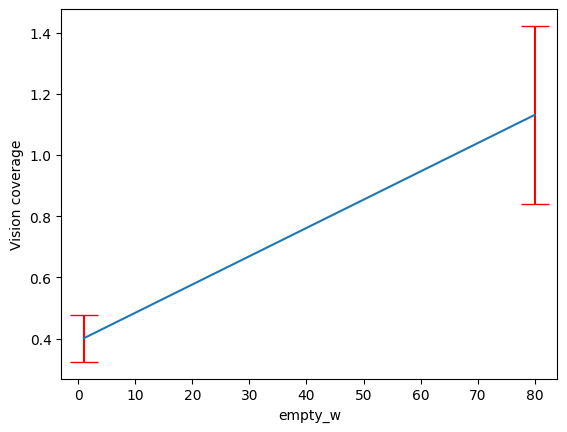

In [464]:
X = np.unique(empty_w)

iv = {"empty_w": [], "v_mean": [], "v_std": []}
for x in X:
    mask = empty_w == x
    group_cubes = cubes[mask, :, :, :]
    group_walls = walls[mask, :, :]

    n_var, n_time, N, _ = group_cubes.shape
    n_per_var = n_time * N * N

    mean_vis = []
    for i_var in range(n_var):
        n_walls = np.isclose(group_walls[i_var], 0.0).sum()
        n_valid = n_per_var - (n_walls * n_time)
        sum_vision = np .sum(group_cubes[i_var, :, :, :])
        mean_vis.append(sum_vision / n_valid)

    iv["empty_w"].append(x)
    iv["v_mean"].append(np.mean(mean_vis))
    iv["v_std"].append(np.std(mean_vis))


iv = pd.DataFrame(iv).sort_values("empty_w")
x = iv["empty_w"]
y = iv["v_mean"]
err = iv["v_std"]

fig, ax = plt.subplots()

#ax.plot(x, y)
ax.errorbar(x, y, err, capsize=10, ecolor="red")
ax.set_ylabel("Vision coverage")
ax.set_xlabel("empty_w")

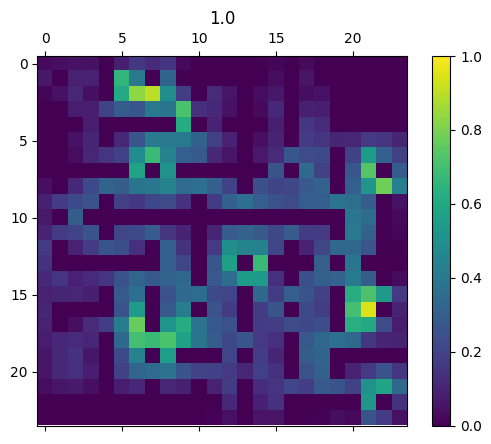

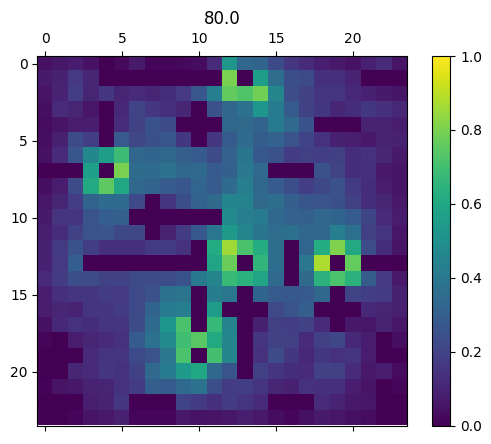

In [465]:
from scipy.signal import convolve2d

def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

# Create a 5x5 Gaussian kernel with sigma = 1
gaussian_filter = gaussian_kernel(7, 0.7)

X = np.unique(empty_w)

for x in X:
    mask = empty_w == x
    cube = cubes[mask, :, :, :]
    cube = cube[np.random.randint(cube.shape[0]), :, :, :]
    # cube = cube[0, :, :, :]
    cube = np.mean(cube, axis=0)
    #   

    fig, ax = plt.subplots()
    ax.set_title(x)
    mappable = ax.matshow(cube, vmin=0, vmax=1)
    fig.colorbar(mappable)
    plt.show()

Text(0, 0.5, 'N of thefts')

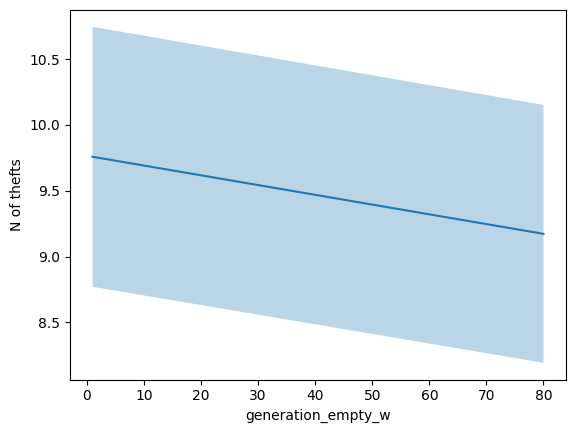

In [23]:
g = analysis.succ_normalized_thefts(df)

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")

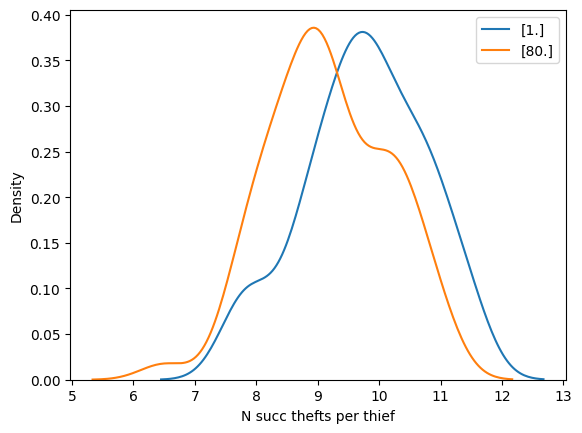

In [30]:
g = analysis.succ_normalized_thefts(df)

fig, ax = plt.subplots()

g.groupby("generation_empty_w").apply(lambda df: sns.kdeplot(df["count"], ax=ax, label=df["generation_empty_w"].unique(), bw_adjust=0.9))

ax.set_xlabel("N succ thefts per thief")
ax.legend()
plt.show()

In [31]:
analysis.t_test_h1(df)

0.0007270346998443582

In [32]:
analysis.mannwhitneyu_test_h1(df)

0.0009769905219976552

<Axes: xlabel='generation_empty_w'>

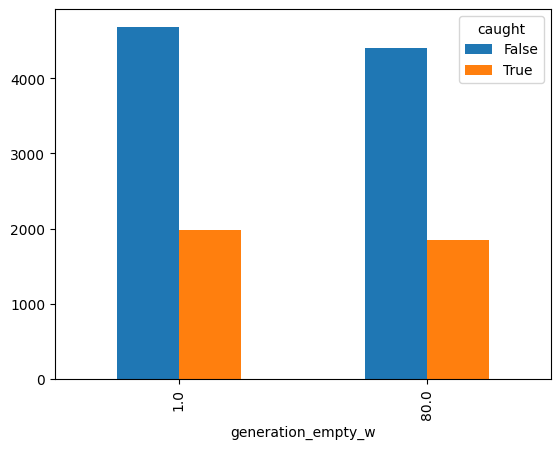

In [28]:
df.groupby(interest)["caught"].value_counts().unstack().plot.bar()

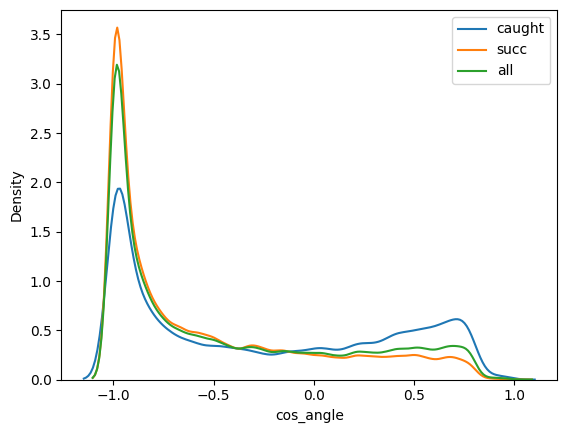

In [389]:
fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()

In [438]:
ts["motivation"].describe()

count    33672.000000
mean         0.743406
std          0.191903
min          0.500000
25%          0.573405
50%          0.720775
75%          0.970795
max          1.000000
Name: motivation, dtype: float64

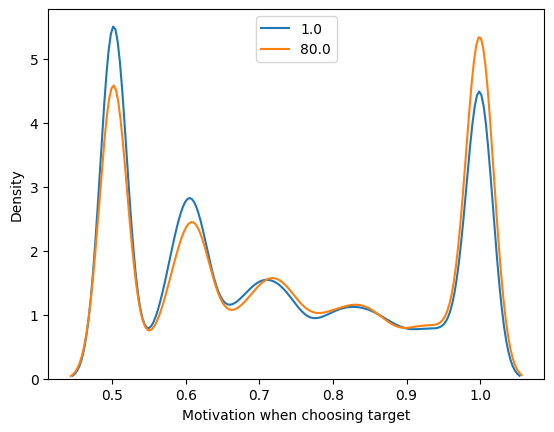

In [483]:
fig, ax = plt.subplots()


for interval in ts[interest].unique():
    empty_bin_df = ts[ts[interest] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "motivation"], bw_adjust=0.6, ax=ax, label=str(interval))

ax: plt.Axes = ax
ax.set_xlabel("Motivation when choosing target")
ax.legend(loc="upper center")
fig.savefig("./data/motivation_distribution.pdf")
plt.show()

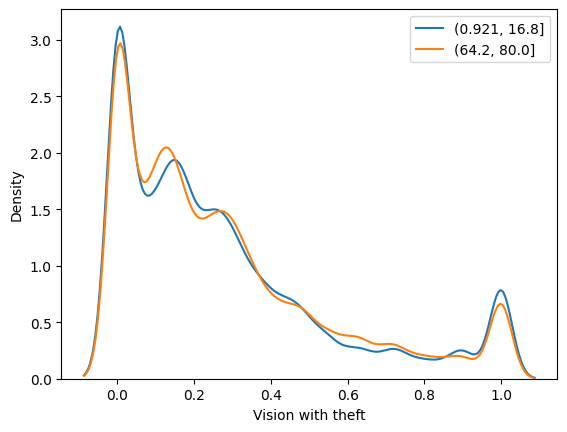

In [484]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "vision"], bw_adjust=0.6, ax=ax, label=str(interval))

ax.set_xlabel("Vision with theft")
ax.legend()
plt.show()

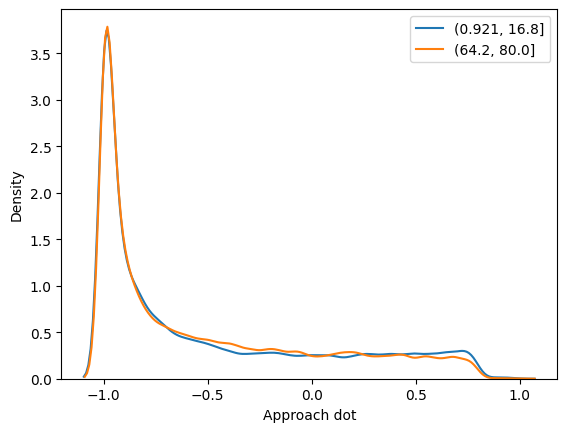

In [236]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label=str(interval))

ax.set_xlabel("Approach dot")
ax.legend()
plt.show()

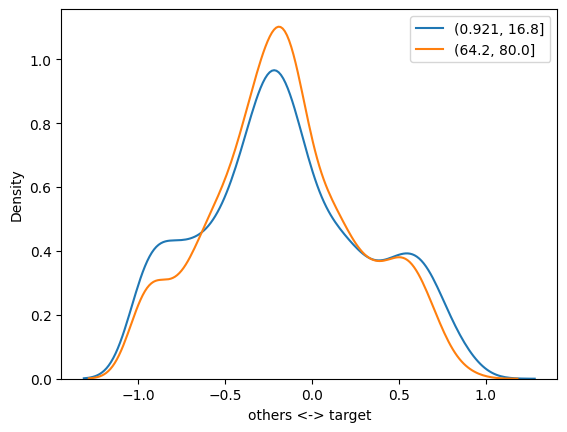

In [394]:
fig, ax = plt.subplots()

df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    caught = empty_bin_df[empty_bin_df["caught"]].copy()
    caught["p_target"] = caught["cos_angle"] / 2 + 0.5
    caught["p_other"] = caught["vision"]

    caught["others <-> target"] = caught["p_target"] - caught["p_other"]

    sns.kdeplot(caught["others <-> target"], ax=ax, label=str(interval))

ax.legend()